In [1]:
import numpy as np
import math


In [3]:
from pathlib import Path
import os

# root = Path(__file__).parent.parent  # top-level directory
root = Path(os.getcwd()).parent  # top-level directory

DATA_PATH = root / "data/"  # datasets and pretrained weights
TRAINING_PATH = root / "outputs/training/"  # training checkpoints
EVAL_PATH = root / "outputs/results/"  # evaluation results


In [4]:
def read_image(path: Path, grayscale: bool = False) -> np.ndarray:
    """Read an image from path as RGB or grayscale"""
    if not Path(path).exists():
        raise FileNotFoundError(f"No image at path {path}.")
    mode = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
    image = cv2.imread(str(path), mode)
    if image is None:
        raise IOError(f"Could not read image at {path}.")
    if not grayscale:
        image = image[..., ::-1]
    return image


In [6]:
import torch
from torch import nn
import torch.nn.functional as F
import os
print(os.getcwd())
from gluefactory.models.deeplsd_inference import DeepLSD

/Users/felixdev/ETH_Informatik_Master/FS24/3D_Vision/glue-factory


In [7]:
def numpy_image_to_torch(image):
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float)

torch.Size([1, 145, 2, 2])


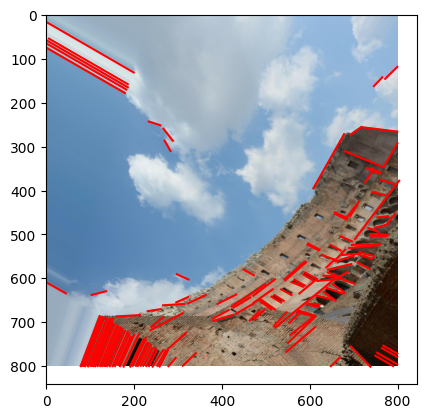

In [41]:
# extract lines for the image
from torchvision.transforms import Resize
from gluefactory.models.lines.deeplsd import DeepLSD
import matplotlib.pyplot as plt
import cv2
from gluefactory.datasets.homographies_deeplsd import sample_homography, warp_lines
from gluefactory.geometry.homography import warp_lines_torch

conf_lines = {
    "min_length": 25,
    "max_num_lines": None,
    "force_num_lines": False,
    "model_conf": {
        "detect_lines": True,
        "line_detection_params": {
            "merge": False,
            "grad_nfa": True,
            "filtering": "normal",
            "grad_thresh": 3.0,
        },
    },

}
size = (800,800)
resize_func = Resize(size)
image_path = "data/mini_depth_100/30623106092_3985ec298a_o.jpg"
homography = sample_homography(size)
img = cv2.resize(cv2.imread(image_path),size)
warped_img = cv2.warpPerspective(img, homography, size,
                                         borderMode=cv2.BORDER_REPLICATE)
warped_img = numpy_image_to_torch(warped_img)

warped_img = warped_img.unsqueeze(0)


model2 = DeepLSD(conf_lines)


model2.eval()
with torch.no_grad():
    pred2 = model2({"image": warped_img})
    
    # pred2 = {k: v[0].cpu().numpy() for k, v in pred2.items()}
    lines = pred2["lines"]
    # line_scores = pred2["line_scores"]
    # valid_lines = pred2["valid_lines"]
    
# Show lines
#print(lines[0][0][0])
print(lines.shape)
lines = lines.numpy()
#lines[0] = warp_lines(lines[0],homography)
warped_img = cv2.cvtColor(warped_img[0].permute(1,2,0).numpy(),cv2.COLOR_BGR2RGB)
plt.imshow(warped_img)
for line in lines[0]:
    plt.plot(line[:, 0], line[:, 1], c='r')
plt.show()

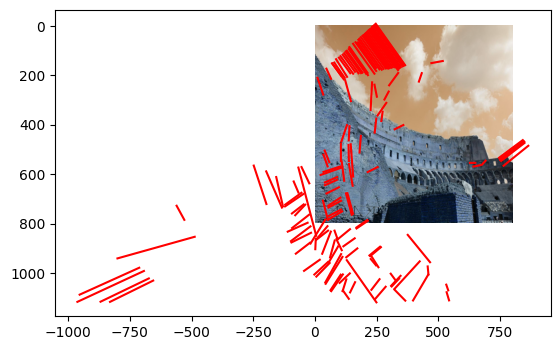

In [45]:
h_inv = np.linalg.inv(homography)
lines[0] = warp_lines(lines[0],homography)
#warped_back_img = cv2.warpPerspective(warped_img, h_inv, size,
#                                         borderMode=cv2.BORDER_REPLICATE)
plt.imshow(img)
for line in lines[0]:
    plt.plot(line[:, 0], line[:, 1], c='r')
plt.show()